In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  
import os
import sys
sys.path.append('..')  # 添加父目录到Python路径
from util.util_ali import print_statistics,loadcsv_dask,add_point_lines,unix_to_Date,date_to_Unix

CHUNK_SIZE = 4096 # 块大小
# 我可能会做一些将多个块看作一个单元的操作


###  1-读写大小分布图

In [2]:
def plot_req_size_cdf(trace_df):
    # 将时间戳转换为datetime格式
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
    # 获取读写请求长度并排序
    read_lengths = df[df['opcode'] == 'R']['length'].astype(int) / 1024  # 转换为KB
    write_lengths = df[df['opcode'] == 'W']['length'].astype(int) / 1024  # 转换为KB

    # 排序
    read_lengths = read_lengths.sort_values().reset_index(drop=True)
    write_lengths = write_lengths.sort_values().reset_index(drop=True)
    
    # 计算CDF
    # 使用numpy的percentile函数计算百分位数
    read_percentiles = np.linspace(0, 100, len(read_lengths))
    write_percentiles = np.linspace(0, 100, len(write_lengths))

    # 1.绘图
    plt.figure(figsize=(12, 8))
    plt.plot(read_lengths.values, read_percentiles, linewidth=2, color='gray', alpha=0.9, label='Read')
    plt.plot(write_lengths.values, write_percentiles, linewidth=2, color='black', alpha=0.9, label='Write')
    
    # 设置坐标轴范围
    plt.xlim(0, plt.gca().get_xlim()[1])  
    plt.ylim(0, 105)  
    # plt.xscale('log')  # 使用对数刻度

    # 2.设置标签和标题
    plt.xlabel('Request Size (KB)', fontsize=14)
    plt.ylabel('Percentage(%)', fontsize=14)
    plt.title('Request Size Distribution', fontsize=16, fontweight='normal')
    
    # 3.添加图例
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4) # 添加网格线    
    plt.tick_params(axis='both', which='major', labelsize=12) # 设置刻度标签大小
    plt.tight_layout(pad=1.5) # 调整布局
    
    # 4.对特殊点添加标注线
    # 计算小于等于4KB的请求百分比
    read_le_4kb = (read_lengths <= 4).mean() * 100
    write_le_4kb = (write_lengths <= 4).mean() * 100

    # 在图表上添加4KB的标记线和标注
    plt.axhline(y=read_le_4kb, xmax=4/plt.gca().get_xlim()[1], color='green', linestyle='--', alpha=1)
    plt.axhline(y=write_le_4kb, xmax=4/plt.gca().get_xlim()[1], color='red', linestyle='--', alpha=1)

    plt.text(4, read_le_4kb, f'4K,R: {read_le_4kb:.0f}%', color='green', ha='right', va='bottom')
    plt.text(4, write_le_4kb, f'4K,W: {write_le_4kb:.0f}%', color='red', ha='right')

    # 计算P90和P99点
    if len(read_lengths) > 0:
        read_p99 = np.percentile(read_lengths, 99)
    else:
        read_p99 = 0
    if len(write_lengths) > 0:
        write_p99 = np.percentile(write_lengths, 99)

    if read_p99 > 0:
        add_point_lines(read_p99, 99, color='green')
    if write_p99 > 0:
        add_point_lines(write_p99, 99, color='red')

    dev_id = df['device_id'].iloc[0]
    time_range = f"{pd.to_datetime(df['timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(df['timestamp'].max()).strftime('%m%d_%H')}" 
    save_dir = f"../SVG/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)  
    plt.savefig(f"{save_dir}/1-Req_Size_CDF_{time_range}.svg", format='svg')
    plt.show()

# 绘制读写大小分布图
# plot_req_size_cdf(global_df)


### 2 请求频率（KIOPS-time）


In [3]:
def plot_req_freq(trace_df, time_interval_seconds):
    """
    绘制请求频率分布图，包括平均IOPS和峰值IOPS
    :param trace_df: 包含跟踪数据的DataFrame
    :param time_interval_seconds: 统计的时间间隔（以秒为单位）
    """
    # 将时间戳转换为datetime格式
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
    
    # 计算IOPS（以秒为统计单位）
    iops = df.groupby(df['timestamp'].dt.floor('1s')).size()

    # 计算平均IOPS和峰值IOPS
    time_interval = f'{time_interval_seconds}s'
    mean_requests = iops.resample(time_interval).mean()  
    peak_iops = iops.resample(time_interval).max() 

    # 绘图
    plt.figure(figsize=(12, 8))
    plt.plot(mean_requests.index, mean_requests.values, 
            label='Average IOPS', 
            color='black',
            linestyle='-',
            linewidth=1)
    
    plt.scatter(peak_iops.index, peak_iops.values,
            label='Peak IOPS(1s)',
            color='gray',
            alpha=1,
            s=2)
    
    plt.xlabel(f'Time (per {time_interval_seconds} seconds)')
    plt.ylabel('Request Frequency (IOPS)')
    plt.title(f'Request Frequency over Time')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # 设置x轴和y轴的范围，使其从0开始
    plt.xlim(df['timestamp'].min(), df['timestamp'].max())
    plt.ylim(0, max(plt.ylim()[1], peak_iops.max()))

    # 保存图像
    dev_id = df['device_id'].iloc[0]
    time_range = f"{pd.to_datetime(df['timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(df['timestamp'].max()).strftime('%m%d_%H')}" 
    save_dir = f"../SVG/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)  
    plt.savefig(f"{save_dir}/2-Request_Freq_{time_range}_{time_interval_seconds}s.svg", format='svg')
    plt.show()

# 绘制请求频率分布图，每1秒统计一次
# plot_req_freq(global_df, 10)


###  3-重用距离分布

In [4]:
# 这个是首次重用距离
from tqdm import tqdm

def plot_first_reuse_distance_cdf(trace_df):
    """
    绘制块首次重用距离的CDF分布图，每个块只统计第一次重用
    重用距离定义为:两次访问之间出现的不同块的数量
    :param trace_df: DataFrame 包含 trace 数据
    """
    # 计算块ID
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')

    df['blk_id'] = df.apply(lambda x: f"{x['device_id']}_{x['offset'] // CHUNK_SIZE}", axis=1) # 每个请求的第一个块ID
    df['end_blk_id'] = df.apply(lambda x: f"{x['device_id']}_{(x['offset'] + x['length']) // CHUNK_SIZE}", axis=1) # 每个请求的最后一个块ID  

    # 添加新列用于保存重用距离
    df['first_rd'] = -1

    # 分别计算读写请求的首次重用距离
    reuse_distances = {'R': [], 'W': []}
    
    # 记录每个块最后一次读写访问位置
    last_read = {}  # 记录每个块最后一次读操作的位置
    last_write = {} # 记录每个块最后一次写操作的位置
    
    # 记录已经计算过首次重用距离的块,每个块只统计一次重用距离
    counted_blocks_read = set()  # 已统计过读重用距离的块集合
    counted_blocks_write = set() # 已统计过写重用距离的块集合
    
    # 遍历数据计算重用距离
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="计算首次重用距离"):
        op_type = row['opcode']
        start_block = row['offset'] // CHUNK_SIZE
        end_block = (row['offset'] + row['length']) // CHUNK_SIZE  # +4095向上取整到4K对齐
        
        for block_num in range(start_block, end_block): # 遍历idx号请求的每个块
            block_id = f"{row['device_id']}_{block_num}"

            if op_type == 'R':
                if block_id in last_read and block_id not in counted_blocks_read:
                    # 如果块之前被读过且未统计过重用距离
                    last_pos = last_read[block_id] # 获取该块最后一次读操作的请求号
            
                    # ?Quick:先写一个不去重的试试速度, 请求长度的和
                    cnt_blks = (df.loc[last_pos+1:idx-1].query("opcode == 'R'")['length'].sum() - CHUNK_SIZE) // CHUNK_SIZE

                    # # 创建一个集合用于存储唯一块ID
                    # unique_blocks_set = set()
                    # # 获取last_pos到idx之间的所有行
                    # blocks_between = df.loc[last_pos+1:idx-1]
                    # # 遍历每一行,将该行涉及的所有块ID加入集合
                    # for _, row in blocks_between.iterrows():
                    #     if row['opcode'] == 'R':
                    #         start_blk = row['blk_id']
                    #         end_blk = row['end_blk_id']
                    #         # 将该行涉及的所有块ID加入集合
                    #         for blk in range(int(start_blk.split('_')[1]), int(end_blk.split('_')[1]) + 1):
                    #             unique_blocks_set.add(f"{row['device_id']}_{blk}")
                    # # 计算唯一块的数量
                    # cnt_blks = len(unique_blocks_set)
                    
                    reuse_distances['R'].append(cnt_blks)
                    counted_blocks_read.add(block_id)  # 标记该块已统计过读重用距离
                last_read[block_id] = idx  # 更新该块最后一次读操作位置

            elif op_type == 'W':
                if block_id in last_write and block_id not in counted_blocks_write:
                    # 如果块之前被写过且未统计过重用距离
                    last_pos = last_write[block_id] # 获取该块最后一次写操作的请求号
                    
                    # ?Quick:先写一个不去重的试试速度, 请求长度的和
                    cnt_blks = (df.loc[last_pos+1:idx-1].query("opcode == 'W'")['length'].sum() - CHUNK_SIZE) // CHUNK_SIZE
                    
                    # # !REAL FIRST REUSE DISTANCE: 
                    # # 从last_pos到idx之间的行, 每行涉及到,df['blk_id'] 至 df["end_blk_id"]块,  统计涉及了多少个无重复
                    # # 块

                    # # 获取last_pos到idx之间的所有行
                    # blocks_between = df.loc[last_pos+1:idx-1]
                    # # 创建一个集合用于存储唯一块ID
                    # unique_blocks_set = set()
                    # # 遍历每一行,将该行涉及的所有块ID加入集合
                    # for _, row in blocks_between.iterrows():
                    #     if row['opcode'] == 'W':
                    #         start_blk = row['blk_id']
                    #         end_blk = row['end_blk_id']
                    #         # 将该行涉及的所有块ID加入集合
                    #         for blk in range(int(start_blk.split('_')[1]), int(end_blk.split('_')[1]) + 1):
                    #             unique_blocks_set.add(f"{row['device_id']}_{blk}")
                    # # 计算唯一块的数量
                    # cnt_blks = len(unique_blocks_set)

                    reuse_distances['W'].append(cnt_blks)
                    # 将重用距离保存到DataFrame中
                    df.at[idx, 'first_rd'] = cnt_blks # 保存到DataFrame中(!但是其实每个请求可能有多个出现重用距离的块哦)
                    counted_blocks_write.add(block_id)  # 标记该块已统计过写重用距离
                last_write[block_id] = idx  # 更新该块最后一次写操作的请求号
                

    # 将重用距离保存到DataFrame中
    
    # 保存数据到CSV文件
    dev_id = df['device_id'].iloc[0]
    time_range = f"{pd.to_datetime(df['timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(df['timestamp'].max()).strftime('%H')}"

    save_dir = f"../data"
    os.makedirs(save_dir, exist_ok=True)
    df.to_csv(f"{save_dir}/dev_{dev_id}_{time_range}.csv", index=False)

    # 绘制CDF图
    plt.figure(figsize=(12, 8))
    
    for op_type in ['R', 'W']:
        if reuse_distances[op_type]:
            distances = [d/1000 for d in sorted(reuse_distances[op_type])]  # 将单位除以1000
            y = np.linspace(0, 1, len(distances))  # 使用linspace生成均匀的y值
            plt.plot(distances, y, label=f'{op_type} operations (First Reuse)')
    
    # plt.xscale('log')
    plt.grid(True)
    plt.title('Distribution of First Reuse Distance')
    plt.xlabel('Reuse Distance (K Blocks)')  # 更新x轴标签单位为K
    plt.ylabel('Cumulative Probability')
    plt.legend()
    
    save_dir = f"../SVG/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)  
    
    plt.savefig(f"{save_dir}/3-1-first_reuse_distance_cdf_{time_range}.svg", format='svg')
    plt.show()


# 相较于上一个,不记录哪个快被计算过, 计算所有的距离
def plot_all_reuse_distance_cdf(trace_df):
    """
    绘制块所有重用距离的CDF分布图
    重用距离定义为:两次访问之间出现的不同块的数量
    :param trace_df: DataFrame 包含 trace 数据
    """
    # 计算块ID
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')

    df['blk_id'] = df.apply(lambda x: f"{x['device_id']}_{x['offset'] // CHUNK_SIZE}", axis=1)
    df['end_blk_id'] = df.apply(lambda x: f"{x['device_id']}_{(x['offset'] + x['length']) // CHUNK_SIZE}", axis=1)

    # 添加新列用于保存重用距离
    df['reuse_distance'] = -1

    # 分别计算读写请求的重用距离
    reuse_distances = {'R': [], 'W': []}
    
    # 记录每个块最后一次读写访问位置
    last_read = {}
    last_write = {}
    
    # 遍历数据计算重用距离
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="计算重用距离"):
        op_type = row['opcode']
        start_block = row['offset'] // CHUNK_SIZE
        end_block = (row['offset'] + row['length']) // CHUNK_SIZE
        
        for block_num in range(start_block, end_block):
            block_id = f"{row['device_id']}_{block_num}"

            if op_type == 'R':
                if block_id in last_read:
                    last_pos = last_read[block_id]
                    cnt_blks = (df.loc[last_pos+1:idx-1].query("opcode == 'R'")['length'].sum() - CHUNK_SIZE) // CHUNK_SIZE
                    reuse_distances['R'].append(cnt_blks)
                last_read[block_id] = idx

            elif op_type == 'W':
                if block_id in last_write:
                    last_pos = last_write[block_id]
                    cnt_blks = (df.loc[last_pos+1:idx-1].query("opcode == 'W'")['length'].sum() - CHUNK_SIZE) // CHUNK_SIZE
                    reuse_distances['W'].append(cnt_blks)
                last_write[block_id] = idx

    # 保存数据到CSV文件
    dev_id = df['device_id'].iloc[0]
    time_range = f"{pd.to_datetime(df['timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(df['timestamp'].max()).strftime('%H')}"
    
    save_dir = f"../data"
    os.makedirs(save_dir, exist_ok=True)
    df.to_csv(f"{save_dir}/dev_{dev_id}_{time_range}_all_reuse.csv", index=False)
    
    # 绘制CDF图
    plt.figure(figsize=(12, 8))
    
    for op_type in ['R', 'W']:
        if reuse_distances[op_type]:
            distances = [d/1000 for d in sorted(reuse_distances[op_type])]
            y = np.linspace(0, 1, len(distances))
            plt.plot(distances, y, label=f'{op_type} operations (All Reuse)')
    
    plt.grid(True)
    plt.title('Distribution of Reuse Distances')
    plt.xlabel('Reuse Distance (K Blocks)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    
    save_dir = f"../SVG/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)
    
    plt.savefig(f"{save_dir}/3-2-all_reuse_distance_cdf_{time_range}.svg", format='svg')
    plt.show()
    
    # 打印一些统计信息
    print("\n重用距离统计信息：")
    for op_type in ['R', 'W']:
        if reuse_distances[op_type]:
            print(f"\n{op_type}操作：")
            print(f"重用距离数量: {len(reuse_distances[op_type])}")
            print(f"平均重用距离: {np.mean(reuse_distances[op_type]):.2f}")
            print(f"中位数重用距离: {np.median(reuse_distances[op_type]):.2f}")
            print(f"最大重用距离: {max(reuse_distances[op_type])}")
            print(f"最小重用距离: {min(reuse_distances[op_type])}")

# TODO: 绘制二次重用的CDF分布图
def plot_twice_rd_CDF(global_df):
    """
    绘制所有块的二次重用距离的CDF分布图
    无视第一次访问，即不记录只访问一次的块,
    """

### 4-绘制访问模式图
包括: 
- 各个块的访问数量分布
- 空间模式(Space)
- 时间模式图(CacheUS)


In [5]:
def plot_access_counts(trace_df):
    """
    访问次数分布图
    """
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')  # unit='us'表示输入的是微秒时间戳
    
    blk_access = {}
    for _, row in df.iterrows():  # iterrows()按行迭代DataFrame
        start_block = row['offset'] // CHUNK_SIZE
        end_block = (row['offset'] + row['length'] + CHUNK_SIZE-1) // CHUNK_SIZE  # +4095向上取整到4K对齐
        # TODO: 这里可以加一个跳出条件,如果timestamp大于给定的时间,则跳出,来减少画图长度
        for block_num in range(start_block, end_block):
            block_id = f"{row['device_id']}_{block_num}"
            if block_id not in blk_access:
                blk_access[block_id] = []
            blk_access[block_id].append(row['timestamp'])
    
    print(f"唯一块数: {len(blk_access)}")
    print("\n访问次数统计:")
    access_counts = {k: len(v) for k, v in blk_access.items()}  # {块ID:访问次数}字典推导式,计算每个块的访问次数
    print(f"访问次数: {{{min(access_counts.values())}~{max(access_counts.values())}}}")
    print(f"平均访问次数: {sum(access_counts.values()) / len(access_counts):.2f}")

    plot_data = []
    for block_id, timestamps in blk_access.items():
        plot_data.extend([(ts, block_id) for ts in timestamps])  # extend()用于列表扩展
    plot_df = pd.DataFrame(plot_data, columns=['timestamp', 'block_id'])
    plot_df.sort_values('timestamp', inplace=True)  # inplace=True表示原地修改

    dev_id = df['device_id'].iloc[0]  # iloc[0]获取第一行
    time_range = f"{df['timestamp'].min().strftime('%m%d_%H')}-{df['timestamp'].max().strftime('%H')}"  # strftime()格式化时间
    save_dir = f"../SVG/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)  # exist_ok=True表示目录存在也不报错

    # 计算访问次数分布
    freq_distribution = {}  # {访问次数: 具有该访问次数的块数量}
    for count in access_counts.values():
        freq_distribution[count] = freq_distribution.get(count, 0) + 1
    
    print("\n访问次数分布统计:")
    for access_time, block_count in sorted(freq_distribution.items()):
        print(f"访问{access_time}次的块数: {block_count}")


    # # 1. 绘制访问次数分布图
    # # 绘制访问次数的CDF图
    # plt.figure(figsize=(12, 8))
    # counts = list(access_counts.values())
    # counts.sort()
    # cdf = np.arange(1, len(counts) + 1) / len(counts)
    
    # plt.plot(counts, cdf, 'b-', linewidth=1, alpha=0.8, color='black')
    # plt.grid(True)
    # plt.xlabel('Access Times')
    # plt.ylabel('CDF')
    # plt.title('Block Access Frequency Distribution')
    
    # # 计算P9和P99的位置
    # p9_idx = int(len(counts) * 0.9)
    # p99_idx = int(len(counts) * 0.99)
    # p9_x, p9_y = counts[p9_idx], cdf[p9_idx]
    # p99_x, p99_y = counts[p99_idx], cdf[p99_idx]
    
    # # 添加P9和P99的标记线
    # add_point_lines(p9_x, p9_y, color='red', alpha=0.5)
    # add_point_lines(p99_x, p99_y, color='green', alpha=0.5)
    
    # 绘制访问次数的柱状图
    plt.figure(figsize=(12, 8))
    plt.xlabel('Access Times')
    plt.ylabel('Block Counts')
    plt.title('Block Access Frequency Distribution')

    counts = list(access_counts.values())
    
    # 计算柱状图的区间
    freq_distribution = sorted(freq_distribution.items())
    min_count = min(freq_distribution)[0]
    max_count = max(freq_distribution)[0]
    # 使用对数分布的bins
    bins = np.logspace(np.log10(min_count), np.log10(max_count), 17)
    
    # 计算P90和P99位置
    counts_sorted = sorted(counts)
    p90_idx = int(len(counts_sorted) * 0.9)
    p99_idx = int(len(counts_sorted) * 0.99)
    p90_value = counts_sorted[p90_idx]
    p99_value = counts_sorted[p99_idx]
    
    # 绘制柱状图并获取返回值
    n, bins, patches = plt.hist(counts,  # 数据数组
                              bins=bins,  # 指定区间边界
                              edgecolor='black',  # 柱子边框颜色
                              color='white',  # 柱子填充颜色
                              alpha=0.7,  # 透明度(0-1)
                              hatch='///')  # 柱子的填充图案
    
    # 在每个柱子中心顶端添加数值标注
    for i in range(len(n)):
        center = (bins[i] + bins[i+1]) / 2
        plt.text(center, n[i], int(n[i]),
                horizontalalignment='center', 
                verticalalignment='bottom')
    
    # 添加P90和P99垂直线
    plt.axvline(x=p90_value, color='red', linestyle='--', alpha=0.5, label=f'P90={p90_value:.0f}')
    plt.axvline(x=p99_value, color='green', linestyle='--', alpha=0.5, label=f'P99={p99_value:.0f}')
    plt.legend()
    print(f"P90: {p90_value:.0f}, P99: {p99_value:.0f}")
    
    # 设置x轴为对数刻度
    plt.xscale('log')
    plt.minorticks_off() # 关闭次刻度
    # 设置x轴刻度值和刻度线
    plt.xticks(bins, [f'{x:.0f}' for x in bins], rotation=30)
    
    plt.grid(True)

    plt.savefig(f"{save_dir}/4-1-blknums-freq_{time_range}.png")
    plt.show()

<!-- 下面两个函数已弃用 -->
2 
3 

In [6]:

def plot_access_space(trace_df):
    """
    绘制每分钟第一个访问的块在后续时间的访问情况。
    :param trace_df: DataFrame 包含 trace 数据
    """
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
    
    # 创建字典来存储块访问记录 {block_id: [timestamp1, timestamp2, timestamp3]}
    blk_access = {}
    df.set_index('timestamp', inplace=True)
    # 对每个请求，计算其覆盖的所有块ID
    for _, row in df.iterrows():
        start_block = row['offset'] // CHUNK_SIZE
        end_block = (row['offset'] + row['length'] + CHUNK_SIZE - 1 ) // CHUNK_SIZE
        
        # 为这个请求范围内的每个块记录访问时间
        for block_num in range(start_block, end_block):
            block_id = f"{row['device_id']}_{block_num}" # 块ID
            if block_id not in blk_access:
                blk_access[block_id] = []
            blk_access[block_id].append(row.name) #  index是timestamp

    print(f"唯一块数: {len(blk_access)}")
    print("\n访问次数统计")
    access_counts = {k: len(v) for k, v in blk_access.items()}
    print(f"最高访问次数: {max(access_counts.values())}")
    print(f"平均访问次数: {sum(access_counts.values()) / len(access_counts):.2f}")

    # 绘图
    plt.figure(figsize=(12, 8))
    plt.title('4-2-Access Pattern (Space)')
    plt.xlabel('Time')
    plt.ylabel('Block ID (Logical Address)')

    plotdata = []
    for block_id, timestamps in blk_access.items():
        block_num = int(block_id.split('_')[1])  # 获取块ID作为y轴坐标
    
        plotdata.extend([(ts, block_num) for ts in timestamps])
    
    plot_df = pd.DataFrame(plotdata, columns=['timestamp', 'block_id'])
    plot_df.sort_values('timestamp', inplace=True)
    
    # 绘制散点图
    plt.scatter(plot_df['timestamp'], plot_df['block_id'],
                s=0.2,
                color='black',
                alpha=0.5,
                marker='.')
        
    plt.gcf().autofmt_xdate()
    
    # 设置y轴刻度,转换为GB单位
    num_ticks = 10
    tick_locations = np.linspace(df['offset'].min() // CHUNK_SIZE, df['offset'].max() // CHUNK_SIZE, num_ticks)
    plt.yticks(tick_locations, [f"{int(loc/1024/1024 * (CHUNK_SIZE/1024)):,}GB" for loc in tick_locations])
    
    plt.grid(True)

    # 保存图片
    time_range = f"{pd.to_datetime(df.index.min()).strftime('%m%d_%H')}-{pd.to_datetime(df.index.max()).strftime('%H')}"
    dev_id = df['device_id'].iloc[0]
    save_dir = f"../SVG/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/4-2-access_space_{time_range}.png")
    plt.show()

# "/home/Data-7T-nvme/lzq/alibaba_block_traces_2020/device.csv"
# plot_access_pattern_space(global_df)


def plot_access_cacheus(trace_df):
    """
    绘制每分钟第一个访问的块在后续时间的访问情况。
    :param trace_df: DataFrame 包含 trace 数据
    """
    # 计算块ID
    df = trace_df.copy()  # 使用副本避免修改原始数据
    df['block_id'] = df.apply(lambda x: f"{x['device_id']}_{x['offset'] // CHUNK_SIZE}", axis=1)

    # 将timestamp转换为datetime格式
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
    
    
    # 创建字典来存储块访问记录 {block_id: [timestamps]}
    blk_access = {}
    # 设置时间索引
    df.set_index('timestamp', inplace=True)
    # 对每个请求，计算其覆盖的所有块ID
    for _, row in df.iterrows():
        start_block = row['offset'] // CHUNK_SIZE
        end_block = (row['offset'] + row['length'] + 4095) // CHUNK_SIZE
        
        # 为这个请求范围内的每个块记录访问时间
        # row.name 是当前行的索引,即timestamp,因为前面设置了 df.set_index('timestamp', inplace=True)
        for block_num in range(start_block, end_block):
            block_id = f"{row['device_id']}_{block_num}"
            if block_id not in blk_access:
                blk_access[block_id] = []
            blk_access[block_id].append(row.name)  # row.name 是timestamp
    
    # 打印一些统计信息
    print(f"唯一块数: {len(blk_access)}")
    print("\n访问次数统计:")
    access_counts = {k: len(v) for k, v in blk_access.items()}
    print(f"最高访问次数: {max(access_counts.values())}")
    print(f"平均访问次数: {sum(access_counts.values()) / len(access_counts):.2f}")

    # 准备绘图数据
    plot_data = []
    for i, (block_id, timestamps) in enumerate(blk_access.items()):
        plot_data.extend([(ts, i) for ts in timestamps]) # blkID按照到达顺序重新编号
    plot_df = pd.DataFrame(plot_data, columns=['timestamp', 'seq_id'])
    plot_df.sort_values('timestamp', inplace=True)

    # 绘图
    plt.figure(figsize=(12, 8))  # 设置图形大小为12x8英寸
    plt.title('4-Access Pattern')  # 设置图表标题
    plt.xlabel('Time')  # 设置x轴标签
    plt.ylabel('SeqID')  # 设置y轴标签

    plt.scatter(plot_df['timestamp'], plot_df['seq_id'], 
            s=0.5,           # 设置点的大小
            color='black',   # 设置颜色为黑色
            alpha=0.1,       # 设置透明度
            marker='.')      # 使用实心圆点

    plt.gcf().autofmt_xdate()  # 自动格式化x轴日期标签，使其倾斜以避免重叠

    seq_id_nums = len(blk_access)    # 获取seqID最大数量(唯一块数量)
    num_ticks = 10  # 固定y轴刻度数量为10个
    # 向上取整到最近的100
    max_y = ((seq_id_nums + 99) // 100) * 100
    # 生成整百的刻度位置
    tick_step = max_y // num_ticks
    tick_step = ((tick_step + 99) // 100) * 100  # 确保tick_step也是整百
    tick_locations = list(range(0, seq_id_nums + tick_step, tick_step))
    plt.yticks(tick_locations, [str(i) for i in tick_locations])  # 设置y轴刻度标签为整百数

    plt.grid(True)  # 添加网格线

    time_range = f"{plot_df['timestamp'].min().strftime('%m%d_%H')}-{plot_df['timestamp'].max().strftime('%m%d_%H')}"
    dev_id = df['device_id'].iloc[0]  
    save_dir = f"../SVG/dev-{dev_id}"  
    os.makedirs(save_dir, exist_ok=True)  
    plt.savefig(f"{save_dir}/4-3-access_cacheus_{time_range}.png") 
    plt.show()  # 显示图形

# 绘制访问模式图（CacheUS）
# plot_access_pattern(global_df)



批量加载数据到  global_df[time_period][dev_idx]

In [7]:
def load(device_id, start_hour=0, duration_hours=2):
    """
    对指定设备进行完整分析并生成所有图表
    
    参数:
    device_id: 设备ID
    start_hour: 开始分析的小时数(从凌晨算起)
    duration_hours: 分析时长(小时)
    """
    # 设置数据文件路径
    trace_file = f"/home/Data-7T-nvme/lzq/alibaba_block_traces_2020/csvfix/device_{device_id}.csv"
    
    # 设置时间范围
    t_0 = pd.Timestamp("2020-01-01 00:00:00")
    current_start = t_0 + pd.Timedelta(hours=start_hour)
    
    print(f"加载设备 {device_id}, 时间范围: {current_start} + {duration_hours}小时")
    
    # 加载数据
    df = loadcsv_dask(
        trace_file,
        blksize="900MB",
        start_time=current_start.strftime("%Y-%m-%d %H:%M:%S.%f"),
        nhours=duration_hours
    )
    
    print_statistics(df)
    return df

### Load

加载设备列表在指定的时间范围内的数据


In [8]:


device_list = [2]  # 指定设备ID列表
df_list = [] 
for dev_id in device_list:
    try:
        df_list.append(load(dev_id, 2, 1)) # 指定时间范围
    except Exception as e:
        print(f"处理设备 {dev_id} 时出错: {str(e)}")
        import traceback
        print(traceback.format_exc())


加载设备 2, 时间范围: 2020-01-01 02:00:00 + 1小时
Dask加载时间: 11.00 秒
        device_id opcode       offset  length         timestamp
279708          2      W  18286796800    4096  1577844000055275
279709          2      W  23836286976   32768  1577844000055349
279710          2      W  23845367808  228352  1577844001055745
279711          2      W  10251395072    4096  1577844002055234
279712          2      W  20652158976    4096  1577844002055291
...           ...    ...          ...     ...               ...
338209          2      W  22792572928    4096  1577847599654894
338210          2      W   3203891200    4096  1577847599654919
338211          2      W  22516211712  221696  1577847599655527
338212          2      W   3155165184    4096  1577847599657028
338213          2      W  11036610560    4096  1577847599657650

[58506 rows x 5 columns]
读写比例: 读 = 6.94%, 写 = 93.06%
请求大小: 0.50 ~ 464.00 KB
地址范围: 28.48 ~ 22904.70 MB
时间范围: 从 2020-01-01 02:00:00.055275 到 2020-01-01 02:59:59.657650


### Plot


        device_id opcode       offset  length         timestamp
279708          2      W  18286796800    4096  1577844000055275
279709          2      W  23836286976   32768  1577844000055349
279710          2      W  23845367808  228352  1577844001055745
279711          2      W  10251395072    4096  1577844002055234
279712          2      W  20652158976    4096  1577844002055291
...           ...    ...          ...     ...               ...
338209          2      W  22792572928    4096  1577847599654894
338210          2      W   3203891200    4096  1577847599654919
338211          2      W  22516211712  221696  1577847599655527
338212          2      W   3155165184    4096  1577847599657028
338213          2      W  11036610560    4096  1577847599657650

[58506 rows x 5 columns]
读写比例: 读 = 6.94%, 写 = 93.06%
请求大小: 0.50 ~ 464.00 KB
地址范围: 28.48 ~ 22904.70 MB
时间范围: 从 2020-01-01 02:00:00.055275 到 2020-01-01 02:59:59.657650
数据量: 58506 条记录
4.1 生成每个块的访问次数分布图...
唯一块数: 64661

访问次数统计:
访问次数: {1

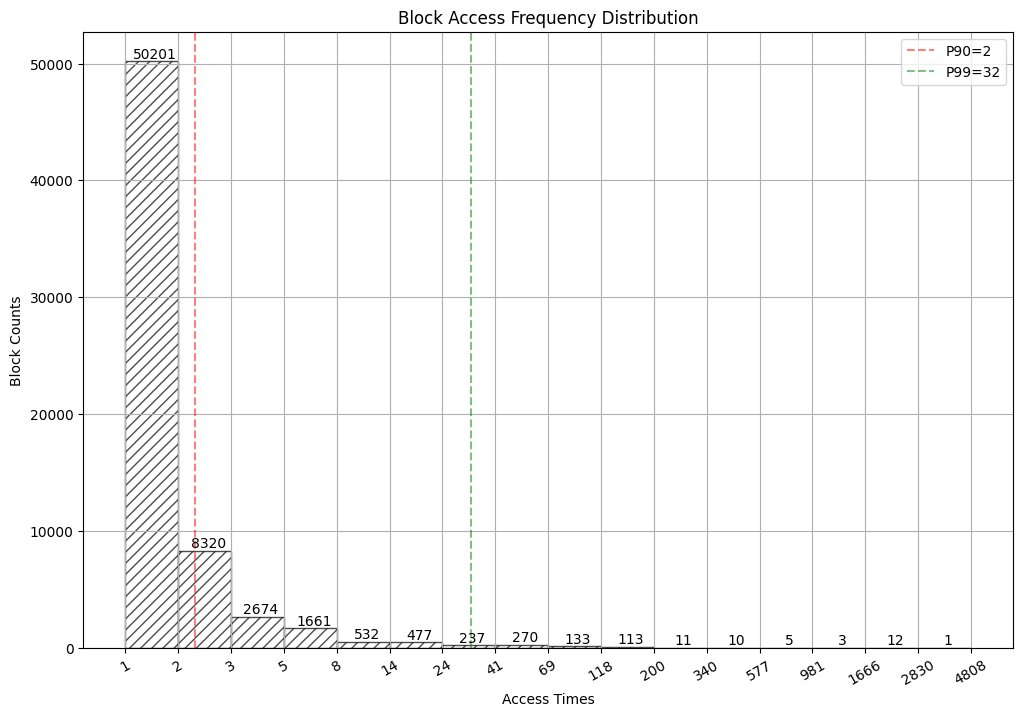

4.2 生成访问空间图...
唯一块数: 64661

访问次数统计
最高访问次数: 4808
平均访问次数: 3.06


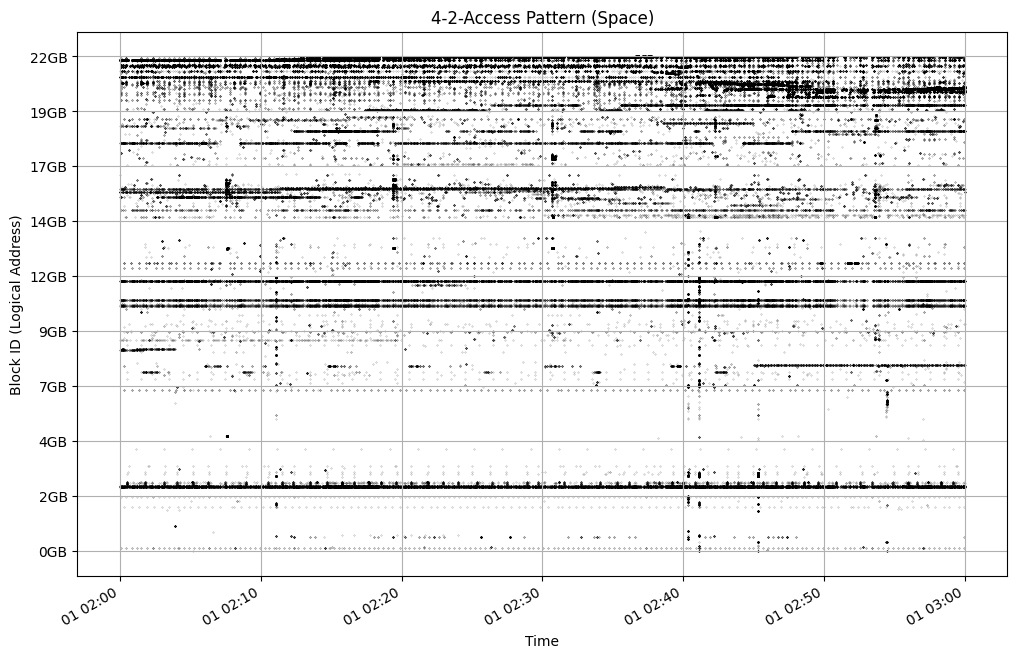

4.3 生成访问模式图...
唯一块数: 64661

访问次数统计:
最高访问次数: 4808
平均访问次数: 3.06


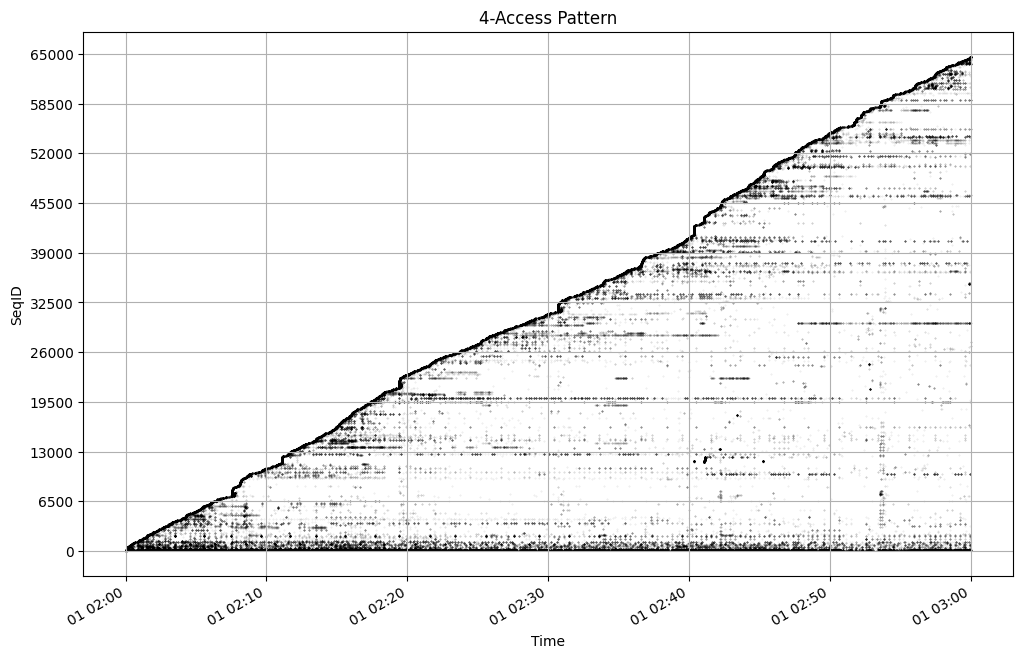

In [9]:

# df = load(2, 0, 12)
# print("1.1 生成请求大小分布图...")
# print_statistics(df)
# plot_req_size_cdf(df)

for df in df_list:
    print_statistics(df)
    print(f"数据量: {len(df)} 条记录")

    # print("1.1 生成请求大小分布图...")
    # plot_req_size_cdf(df)

    # print("2.1 IOPS波动图...")
    # plot_req_freq(df, 10)

    # print("3.1 生成首次重用距离分布图...")
    # plot_first_reuse_distance_cdf(df)
    # print("3.2 生成所有重用距离分布图...")
    # plot_all_reuse_distance_cdf(df)

    print("4.1 生成每个块的访问次数分布图...")
    plot_access_counts(df)
    print("4.2 生成访问空间图...")
    plot_access_space(df)
    print("4.3 生成访问模式图...")
    plot_access_cacheus(df)


